In [1]:
### Pytorch geometry (グラフニューラルネットワークライブラリ) のインストール(only first time)
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [2]:
# ライブラリ確認
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
import torch
from torch_geometric.data import Data as TorchGeometricData

print(Chem.__doc__)

 A module for molecules and stuff

 see Chem/index.html in the doc tree for documentation




In [3]:
#SDFファイルの読み込み
import glob
import re

suppl  = Chem.SDMolSupplier("../../ForMolPredict/SDF_files/SOL/SOL_AllMOL.sdf",removeHs=False) 
mol_list = [x for x in suppl]
mol_num = len(mol_list)
print("there are {} molecules".format(mol_num))

there are 1214 molecules


In [4]:
#detaの分割
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(mol_list, random_state=0)
train, val = train_test_split(train_val)

In [5]:
## pandasのデータフレームからRDkitのmolオブジェクトXとラベルYのペアに変換

Xwf={dataset_keyword:[] for dataset_keyword in ["train","valid","test"]}
Ywf={dataset_keyword:[] for dataset_keyword in ["train","valid","test"]}
#(A) lowを０それ以外を１とする
for mol in train: 
    Xwf["train"].append(mol)
    if mol.GetProp('SOL_class')=='(A) low':
        Ywf["train"].append(0.0)
    else:
        Ywf["train"].append(1.0)
for mol in val: 
    Xwf["valid"].append(mol)
    if mol.GetProp('SOL_class')=='(A) low':
        Ywf["valid"].append(0.0)
    else:
        Ywf["valid"].append(1.0)
for mol in test:
    Xwf["test"].append(mol)
    if mol.GetProp('SOL_class')=='(A) low':
        Ywf["test"].append(0.0)
    else:
        Ywf["test"].append(1.0)

In [6]:

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception(
            "input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def get_atom_features(atom, en_list=None, explicit_H=False, use_sybyl=False, use_electronegativity=False,
                  use_gasteiger=False, degree_dim=17):
    if use_sybyl:
        atom_type = ordkit._sybyl_atom_type(atom)
        atom_list = ['C.ar', 'C.cat', 'C.1', 'C.2', 'C.3', 'N.ar', 'N.am', 'N.pl3', 'N.1', 'N.2', 'N.3', 'N.4', 'O.co2',
                     'O.2', 'O.3', 'S.O', 'S.o2', 'S.2', 'S.3', 'F', 'Si', 'P', 'P3', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
                     'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                     'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']
    else:
        atom_type = atom.GetSymbol()
        atom_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V',
                     'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
                     'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']
    results = one_of_k_encoding_unk(atom_type, atom_list) + \
        one_of_k_encoding(atom.GetDegree(), list(range(degree_dim))) + \
        one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
        [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
        one_of_k_encoding_unk(atom.GetHybridization(),
                              [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                               Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                               Chem.rdchem.HybridizationType.SP3D2]) + \
        [atom.GetIsAromatic()]

    if use_electronegativity:
        results = results + [en_list[atom.GetAtomicNum() - 1]]
    if use_gasteiger:
        gasteiger = atom.GetDoubleProp('_GasteigerCharge')
        if np.isnan(gasteiger) or np.isinf(gasteiger):
            gasteiger = 0  # because the mean is 0
        results = results + [gasteiger]

    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
        results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])
    return np.array(results, dtype=np.float32)

def get_bond_features(bond):
  results=one_of_k_encoding_unk(bond.GetBondType(),[Chem.rdchem.BondType.SINGLE,
                         Chem.rdchem.BondType.DOUBLE,
                         Chem.rdchem.BondType.TRIPLE,
                         Chem.rdchem.BondType.AROMATIC])
  return np.array(results, dtype=np.float32)

In [7]:
import torch
from rdkit import Chem
from torch_geometric.data import Data as TorchGeometricData
from torch_geometric.data import DataLoader

def get_edge_features(mol):
    edge_list= []
    num_bond_features=0
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_features = get_bond_features(bond)
        num_bond_features=len(bond_features)
        edge_list += [([i, j],bond_features), ([j, i],bond_features)]
    return edge_list, num_bond_features

#modified mol2geodata
#規格化関数
def rescaling(features):
    norm_features = []
    max_value = max(features)
    min_value = min(features)
    for feature in features:
        norm_feature = (feature - min_value)/(max_value - min_value)
        norm_features.append(norm_feature)
    
    return norm_features

def get_WF_results(mol):
    mol_props = ['Volume', 'Energy', 'HOMO', 'LUMO', 'HLgap', 'Mcharge_ave', 'Mcharge_var', 'Lcharge_ave', 'Lcharge_var', 'dipole', 'Atom_num', 'Mass', 'Density']
    atom_props = ['Mcharges', 'Lcharges', 'Mass', 'X_dem', 'Y_dem', 'Z_dem']
    mol_datalist = []
    WF_results = []
    for mol_prop in mol_props:
        mol_datalist.append(mol.GetDoubleProp(mol_prop))
    for atom in mol.GetAtoms():
        atom_data = []
        for atom_prop in atom_props:
            atom_data.append(atom.GetDoubleProp(atom_prop))
            molatom_data = mol_datalist + atom_data
        WF_results.append(molatom_data)
    return np.array(WF_results, dtype=np.float32)

def mol2geodataWF(mol,y):
    smile = Chem.MolToSmiles(mol)
    atom_features =[get_atom_features(atom) for atom in mol.GetAtoms()]
    WF_results = get_WF_results(mol)
    atom_features = np.append(atom_features, WF_results, axis=1)
    num_atom_features=len(atom_features[0])
    atom_features = torch.FloatTensor(atom_features).view(-1, len(atom_features[0]))

    edge_list,num_bond_features = get_edge_features(mol)
    edge_list=sorted(edge_list)
    
    edge_indices=[e for e,v in edge_list]
    edge_attributes=[v for e,v in edge_list]
    edge_indices = torch.tensor(edge_indices)
    edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    edge_attributes = torch.FloatTensor(edge_attributes)
    #print(num_atom_features,num_bond_features)
    return TorchGeometricData(x=atom_features, edge_index=edge_indices, edge_attr=edge_attributes, num_atom_features=num_atom_features,num_bond_features=num_bond_features,smiles=smile, y=y)  

In [8]:
train_data_list = [mol2geodataWF(mol,y) for mol,y in zip(Xwf["train"],Ywf["train"])]
train_loader = DataLoader(train_data_list, batch_size=128,shuffle=True)

valid_data_list = [mol2geodataWF(mol,y) for mol,y in zip(Xwf["valid"],Ywf["valid"])]
valid_loader = DataLoader(valid_data_list, batch_size=128,shuffle=True)

test_data_list = [mol2geodataWF(mol,y) for mol,y in zip(Xwf["test"],Ywf["test"])]
test_loader = DataLoader(test_data_list, batch_size=128,shuffle=True)

/home/kuma/anaconda3/envs/chem/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
num_atom_features = train_data_list[0].num_atom_features
num_bond_features = train_data_list[0].num_bond_features

print("num_atom_features =",num_atom_features)
print("num_bond_features =",num_bond_features)

num_atom_features = 100
num_bond_features = 4


In [10]:
# ニューラルネットワークの構造の定義

import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU
import torch_geometric.transforms as T
from torch_geometric.nn import NNConv, Set2Set

dim = 64 # 中間層の次元

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin0 = torch.nn.Linear(num_atom_features, dim)

        nn = Sequential(Linear(num_bond_features, 128), ReLU(), Linear(128, dim * dim))
        self.conv = NNConv(dim, dim, nn, aggr='mean')
        self.gru = GRU(dim, dim)

        self.set2set = Set2Set(dim, processing_steps=3)
        self.lin1 = torch.nn.Linear(2 * dim, dim)
        self.lin2 = torch.nn.Linear(dim, 1)

    def forward(self, data):
        out = F.relu(self.lin0(data.x))
        h = out.unsqueeze(0)

        for i in range(3):
            m = F.relu(self.conv(out, data.edge_index, data.edge_attr))
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)

        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)

In [11]:
# ニューラルネットワークの学習パラメータの定義

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.7, patience=5,min_lr=0.00001)
loss_function = torch.nn.BCEWithLogitsLoss()

def train_step(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_function(model(data), data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test_step(loader):
    model.eval()
    loss_all = 0
    for data in loader:
        data = data.to(device)
        loss = loss_function(model(data), data.y)
        loss_all += loss.item() * data.num_graphs
    return loss_all / len(loader.dataset)

In [12]:
# 学習開始
Epoch_list = []
Loss_list = []
Val_list = []
Test_list =[]
best_valid_loss = None
for epoch in range(200):
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss = train_step(epoch)
    valid_loss = test_step(valid_loader)
    scheduler.step(valid_loss)

    if best_valid_loss is None or valid_loss <= best_valid_loss:
        test_loss = test_step(test_loader)
        best_valid_loss = valid_loss
    Epoch_list.append(epoch)
    Loss_list.append(loss)
    Val_list.append(valid_loss)
    Test_list.append(test_loss)
    print('Epoch: {:03d}, LR: {:7f}, Loss: {:.7f}, Validation loss: {:.7f}, '
          'Test loss: {:.7f}'.format(epoch, lr, loss, valid_loss, test_loss))

Epoch: 000, LR: 0.001000, Loss: 1.1022893, Validation loss: 0.7813503, Test loss: 0.7936083
Epoch: 001, LR: 0.001000, Loss: 0.7509977, Validation loss: 0.6890599, Test loss: 0.6853815
Epoch: 002, LR: 0.001000, Loss: 0.7763703, Validation loss: 0.6077581, Test loss: 0.6216355
Epoch: 003, LR: 0.001000, Loss: 0.5851493, Validation loss: 0.5758690, Test loss: 0.5758689
Epoch: 004, LR: 0.001000, Loss: 0.6102653, Validation loss: 0.5740793, Test loss: 0.5740344
Epoch: 005, LR: 0.001000, Loss: 0.5767765, Validation loss: 0.5125458, Test loss: 0.5281407
Epoch: 006, LR: 0.001000, Loss: 0.5219769, Validation loss: 0.5413732, Test loss: 0.5281407
Epoch: 007, LR: 0.001000, Loss: 0.5152275, Validation loss: 0.5674338, Test loss: 0.5281407
Epoch: 008, LR: 0.001000, Loss: 0.5497352, Validation loss: 0.5466520, Test loss: 0.5281407
Epoch: 009, LR: 0.001000, Loss: 0.5349560, Validation loss: 0.4862863, Test loss: 0.4902830
Epoch: 010, LR: 0.001000, Loss: 0.5306335, Validation loss: 0.5513079, Test loss

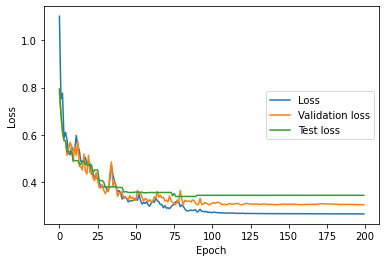

In [13]:
#グラフ化
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.plot(Epoch_list, Loss_list, label = 'Loss')
plt.plot(Epoch_list, Val_list, label = 'Validation loss')
plt.plot(Epoch_list, Test_list, label = 'Test loss')

# 凡例を表示
plt.legend(loc=5)

# 軸ラベル
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()